In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import gradio as gr

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/luvgambhir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luvgambhir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/luvgambhir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove punctuation/special chars
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


In [5]:
def preprocess_dataframe(file_path):
    df = pd.read_excel(file_path)
    df.dropna(subset=['ticket_text', 'issue_type', 'urgency_level'], inplace=True)
    df['clean_text'] = df['ticket_text'].apply(clean_text)
    return df

# Load data
df = preprocess_dataframe('/Users/luvgambhir/Documents/ai_dev_assignment_tickets_complex_1000.xls')
print(df.head())


   ticket_id                                        ticket_text  \
0          1  Payment issue for my SmartWatch V2. I was unde...   
2          3  I ordered SoundWave 300 but got EcoBreeze AC i...   
3          4  Facing installation issue with PhotoSnap Cam. ...   
5          6  Can you tell me more about the PhotoSnap Cam w...   
6          7   is malfunction. It stopped working after just...   

           issue_type urgency_level        product  \
0     Billing Problem        Medium  SmartWatch V2   
2          Wrong Item        Medium  SoundWave 300   
3  Installation Issue           Low  PhotoSnap Cam   
5     General Inquiry        Medium  PhotoSnap Cam   
6      Product Defect           Low   EcoBreeze AC   

                                          clean_text  
0  payment issue smartwatch v2 underbilled order ...  
2  ordered soundwave 300 got ecobreeze ac instead...  
3  facing installation issue photosnap cam setup ...  
5     tell photosnap cam warranty also available red

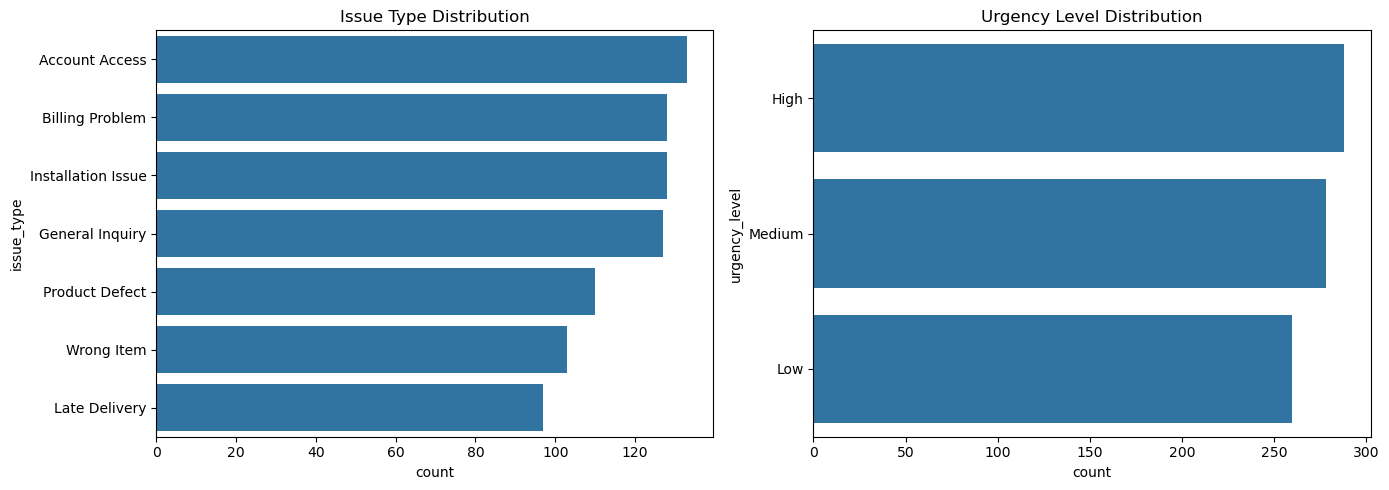

In [7]:
def plot_distributions(df):
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    sns.countplot(y='issue_type', data=df, order=df['issue_type'].value_counts().index)
    plt.title('Issue Type Distribution')
    
    plt.subplot(1, 2, 2)
    sns.countplot(y='urgency_level', data=df, order=df['urgency_level'].value_counts().index)
    plt.title('Urgency Level Distribution')
    
    plt.tight_layout()
    plt.show()

plot_distributions(df)


In [9]:
def extract_features(df):
    tfidf = TfidfVectorizer(max_features=500)
    X_tfidf = tfidf.fit_transform(df['clean_text'])
    df['ticket_length'] = df['clean_text'].apply(lambda x: len(x.split()))
    df['sentiment_score'] = df['ticket_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    length_reshape = np.array(df['ticket_length']).reshape(-1, 1)
    sentiment_reshape = np.array(df['sentiment_score']).reshape(-1, 1)
    X_all = hstack([X_tfidf, length_reshape, sentiment_reshape])
    return X_all, tfidf

X_all, tfidf = extract_features(df)


Classification report for Issue Type:
                    precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        23
   Billing Problem       1.00      1.00      1.00        19
   General Inquiry       1.00      1.00      1.00        25
Installation Issue       1.00      1.00      1.00        29
     Late Delivery       1.00      1.00      1.00        17
    Product Defect       1.00      1.00      1.00        30
        Wrong Item       1.00      1.00      1.00        23

          accuracy                           1.00       166
         macro avg       1.00      1.00      1.00       166
      weighted avg       1.00      1.00      1.00       166



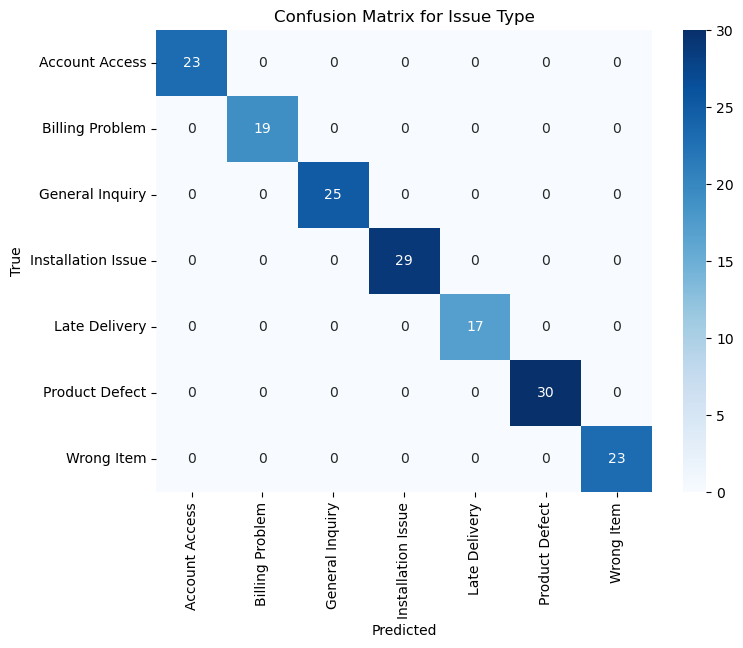

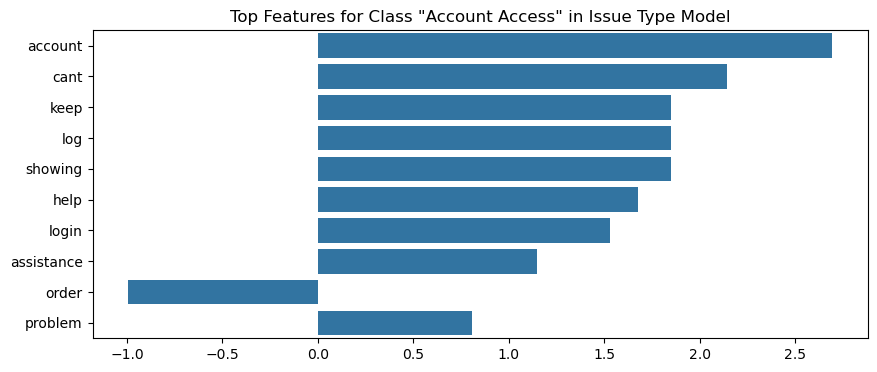

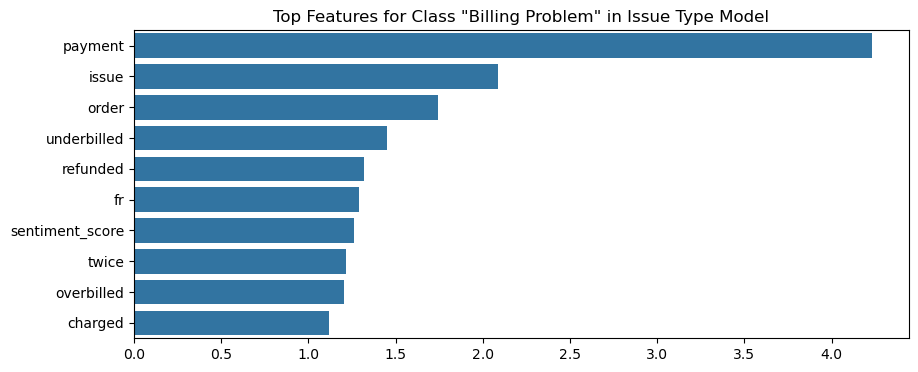

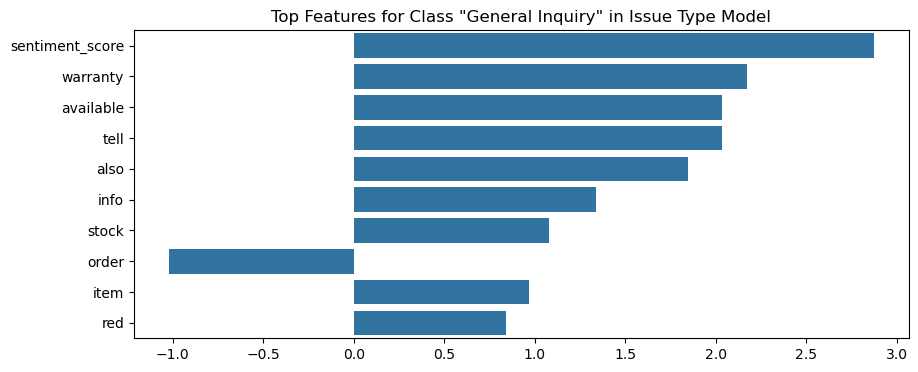

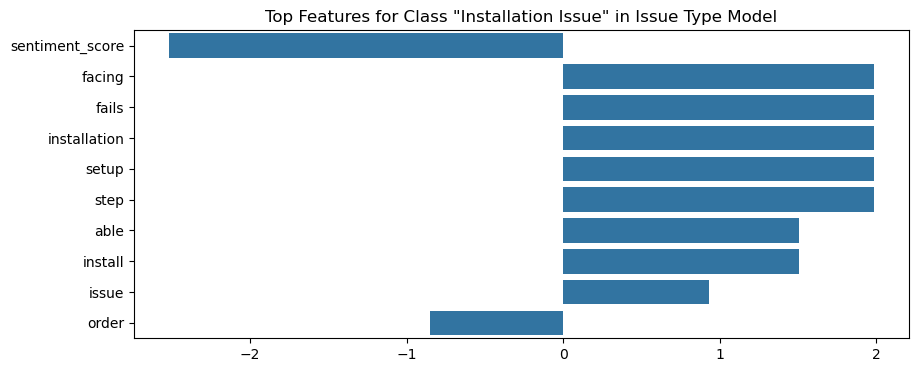

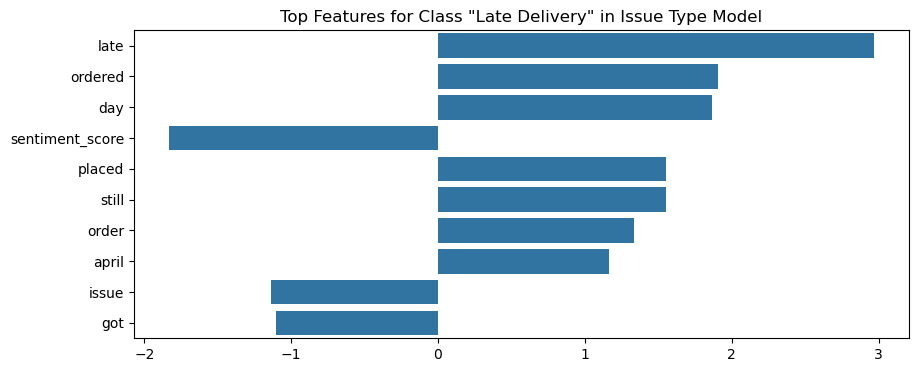

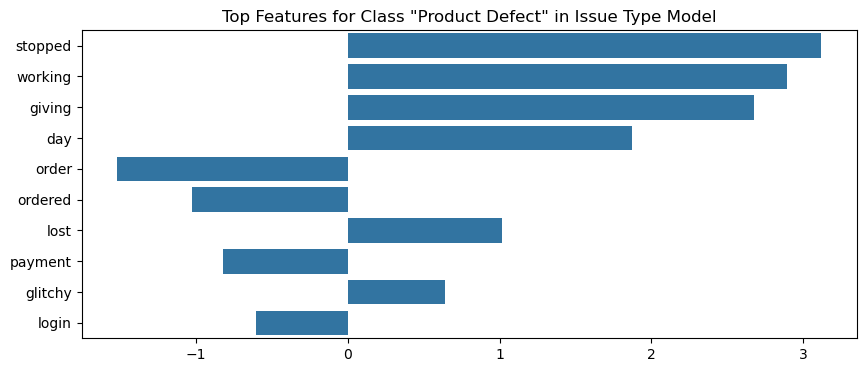

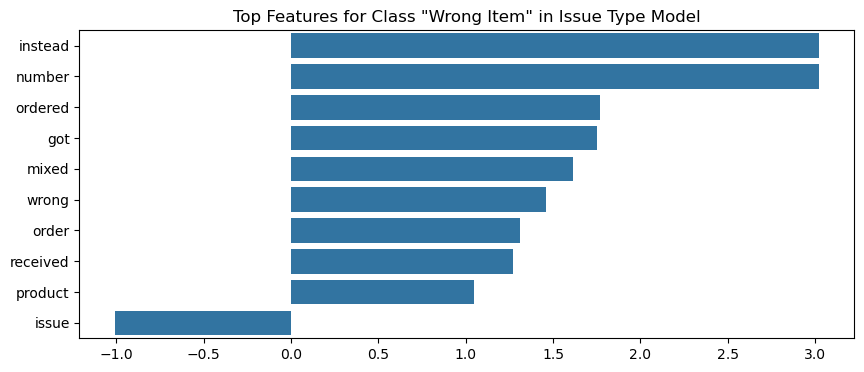

Classification report for Urgency Level:
              precision    recall  f1-score   support

        High       0.38      0.30      0.34        66
         Low       0.26      0.28      0.27        43
      Medium       0.33      0.39      0.36        57

    accuracy                           0.33       166
   macro avg       0.32      0.32      0.32       166
weighted avg       0.33      0.33      0.33       166



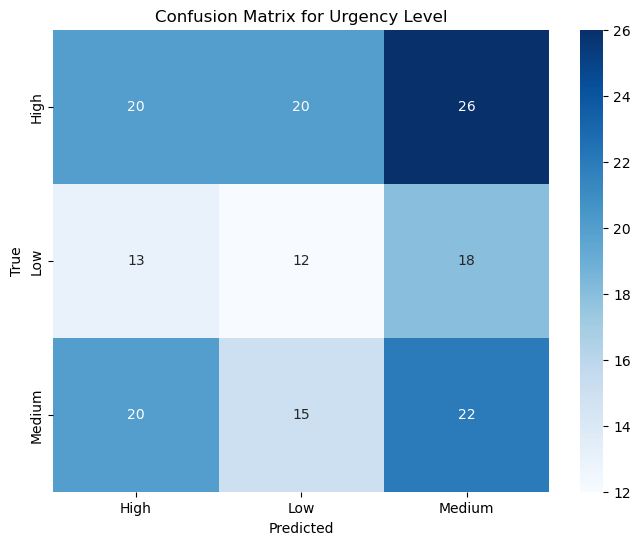

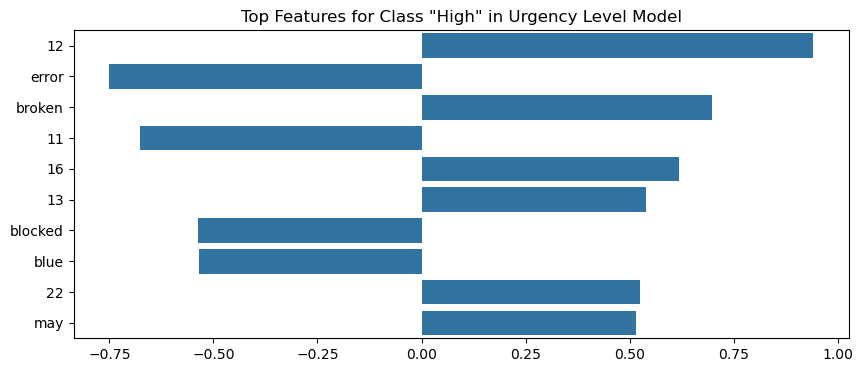

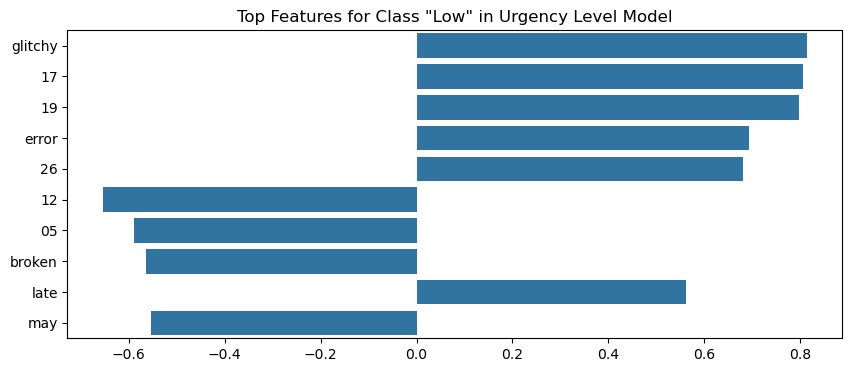

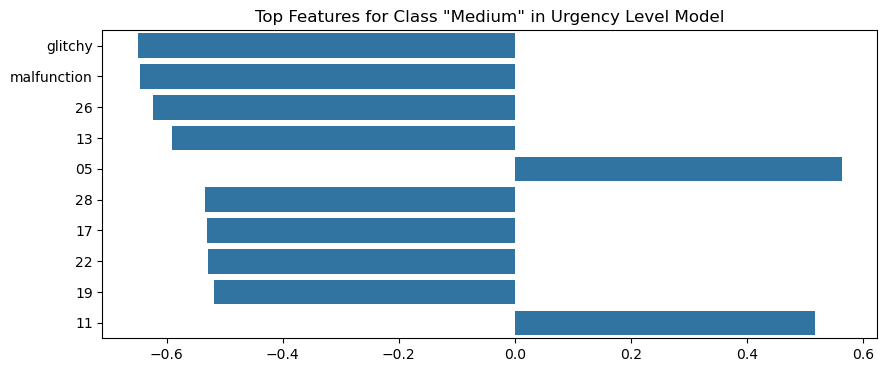

In [11]:
def train_classifier(X, y, label_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Classification report for {label_name}:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label_name}')
    plt.show()
    
    # Feature importance plot (for tfidf features only)
    feature_names = list(tfidf.get_feature_names_out()) + ['ticket_length', 'sentiment_score']
    coefs = model.coef_
    if coefs.shape[0] == 1:
        top_features = sorted(zip(coefs[0], feature_names), key=lambda x: abs(x[0]), reverse=True)[:20]
    else:
        for i, class_label in enumerate(model.classes_):
            top_features = sorted(zip(coefs[i], feature_names), key=lambda x: abs(x[0]), reverse=True)[:10]
            plt.figure(figsize=(10,4))
            sns.barplot(x=[coef for coef, feat in top_features], y=[feat for coef, feat in top_features])
            plt.title(f'Top Features for Class "{class_label}" in {label_name} Model')
            plt.show()

    return model

issue_model = train_classifier(X_all, df['issue_type'], "Issue Type")
urgency_model = train_classifier(X_all, df['urgency_level'], "Urgency Level")


In [13]:
COMPLAINT_KEYWORDS = ['broken', 'error', 'issue', 'delay', 'late', 'missing', 'failed', 'not working']
PRODUCT_LIST = ['WidgetX', 'GadgetPro', 'ServiceZ']

def extract_entities(text):
    entities = {
        'products': [],
        'dates': [],
        'keywords': []
    }
    for product in PRODUCT_LIST:
        if product.lower() in text.lower():
            entities['products'].append(product)
    date_matches = re.findall(r'\b(?:\d{1,2}[/-])?(?:\d{1,2}[/-])?\d{2,4}\b', text)
    entities['dates'].extend(date_matches)
    for kw in COMPLAINT_KEYWORDS:
        if re.search(rf'\b{kw}\b', text.lower()):
            entities['keywords'].append(kw)
    return entities


In [15]:
def predict_and_extract(raw_text, issue_model, urgency_model, tfidf):
    cleaned = clean_text(raw_text)
    features = tfidf.transform([cleaned])
    length = np.array([[len(cleaned.split())]])
    sentiment = np.array([[TextBlob(raw_text).sentiment.polarity]])
    X_combined = hstack([features, length, sentiment])
    issue_pred = issue_model.predict(X_combined)[0]
    urgency_pred = urgency_model.predict(X_combined)[0]
    entities = extract_entities(raw_text)
    return {
        'issue_type': issue_pred,
        'urgency_level': urgency_pred,
        'entities': entities
    }


In [17]:
def batch_predict(texts):
    results = []
    for text in texts:
        pred = predict_and_extract(text, issue_model, urgency_model, tfidf)
        results.append({
            "Ticket Text": text,
            "Issue Type": pred['issue_type'],
            "Urgency Level": pred['urgency_level'],
            "Extracted Entities": pred['entities']
        })
    return pd.DataFrame(results)

gr_interface = gr.Interface(
    fn=batch_predict,
    inputs=gr.Textbox(lines=10, placeholder="Enter multiple tickets separated by new lines..."),
    outputs=gr.Dataframe(headers=["Ticket Text", "Issue Type", "Urgency Level", "Extracted Entities"]),
    title="Ticket Classification and Entity Extraction",
    description="Input multiple ticket texts (one per line) to get issue type, urgency level, and extracted entities."
)

if __name__ == "__main__":
    gr_interface.launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
